# Introduction

In this notebook, we explore **Singular Value Decomposition (SVD)** as a technique for **image compression**, using the **Olivetti Faces dataset**. SVD is a powerful linear algebra method commonly used in unsupervised learning for tasks such as:

- **Dimensionality reduction**
- **Latent structure discovery**
- **Noise filtering**
- **Matrix approximation**

While PCA performs SVD under the hood on the covariance matrix, this notebook focuses on applying SVD **directly to pixel matrices**, showing how we can reduce image complexity while preserving key visual features.


## What is SVD?

SVD decomposes a matrix $ A $ into three components:

$$
A = U \Sigma V^T
$$

Where:
- $ U $ and $ V^T $ are orthogonal matrices representing left and right singular vectors
- $ \Sigma $ is a diagonal matrix of singular values, which reflect the importance of each component

By keeping only the top $ k $ singular values and vectors, we can reconstruct a low-rank approximation of the original matrix:

$$
A_k = U_k \Sigma_k V_k^T
$$

###Why SVD?

- Image matrices (like the 64x64 pixel face images used here) can be compressed by keeping only the most significant singular values.
- This allows us to **retain essential structure** (edges, shadows, facial contours) while reducing storage size.
- SVD is **lossy but efficient** — useful when full detail is unnecessary, or memory/storage constraints exist.



This notebook contributes to the broader unsupervised learning collection by demonstrating **SVD as both a standalone compression tool and a building block for other methods** like:

- **PCA** (which relies on SVD under the hood)
- **Latent Semantic Analysis (LSA)** for text data
- **Recommender systems** and **topic modeling**

## In this notebook we will 

- Use both `numpy.linalg.svd` and a **from-scratch SVD implementation** to compress images at different levels (varying \( k \)).
- Visualize how image quality improves as more components are retained.
- Compare built-in and manual implementations to build intuition and verify correctness.


## Load Data 

- The **Olivetti Faces dataset** is loaded, consisting of 400 grayscale facial images (64×64).
- We select one image to serve as a baseline for compression and reconstruction.

In [4]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

# Load the Olivetti Faces dataset
faces = fetch_olivetti_faces()
images = faces.images  # shape: (400, 64, 64)

# Select one image to demonstrate SVD compression
original_image = images[17]

## NumPy SVD function
- This function compresses an image using **Singular Value Decomposition (SVD)** by retaining only the top `k` singular values/vectors.
- The compressed image is a low-rank approximation that preserves the most significant features.


In [5]:
# Function to compress an image using SVD with a given number of components
def svd_compress(image, k):
    U, S, VT = np.linalg.svd(image, full_matrices=False)
    S_k = np.diag(S[:k])
    compressed = U[:, :k] @ S_k @ VT[:k, :]
    return compressed


## Visualize 
- This function compresses an image using **Singular Value Decomposition (SVD)** by retaining only the top `k` singular values/vectors.
- The compressed image is a low-rank approximation that preserves the most significant features.

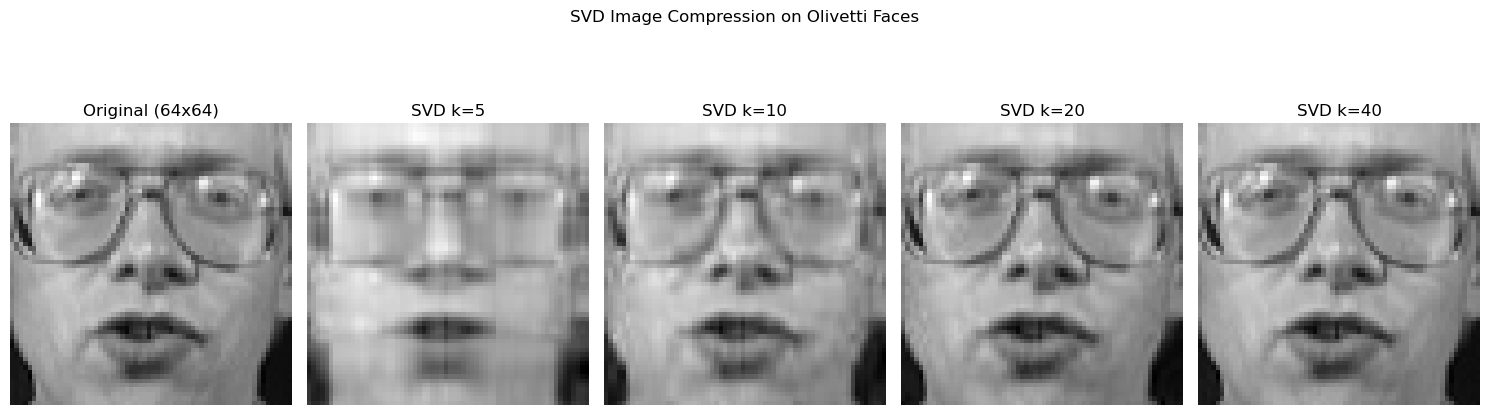

In [6]:

# Visualize original and compressed versions for multiple values of k
ks = [5, 10, 20, 40]
fig, axes = plt.subplots(1, len(ks) + 1, figsize=(15, 5))
# Plot original
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original (64x64)")
axes[0].axis('off')

# Plot compressed versions
for i, k in enumerate(ks):
    compressed_img = svd_compress(original_image, k)
    axes[i + 1].imshow(compressed_img, cmap='gray')
    axes[i + 1].set_title(f"SVD k={k}")
    axes[i + 1].axis('off')

plt.suptitle("SVD Image Compression on Olivetti Faces")
plt.tight_layout()
plt.show()



- **k = 5**: The image is heavily compressed, retaining only basic contours. Facial details are blurred, but the rough shape is preserved.
- **k = 10**: Edges become sharper, and key features like eyes and nose begin to emerge.
- **k = 20**: Much of the face is now visible with good structure and shading.
- **k = 40**: The image is nearly indistinguishable from the original, showing minimal loss.

 Even with 10–20 singular values (out of 64), we can reconstruct a face with acceptable fidelity. This highlights SVD’s ability to reduce dimensionality while preserving key structure.


## From Scratch Implementaion 
- Implements a **from-scratch SVD** using the **power iteration method**:
  1. Iteratively computes singular vectors (one at a time).
  2. Deflates the matrix after extracting each component.
- This method is **computationally simple**, and builds intuition behind how SVD decomposes structure one vector at a time.

In [7]:

# Reload Olivetti faces dataset
faces = fetch_olivetti_faces()
image = faces.images[0]

# From-scratch approximation: Top-k SVD using power iteration
def power_iteration_svd(A, k, n_iter=100):
    m, n = A.shape
    U, S, VT = [], [], []

    A_copy = A.copy()
    for _ in range(k):
        # Step 1: initialize random vector
        x = np.random.rand(n)
        for _ in range(n_iter):
            x = A_copy.T @ (A_copy @ x)
            x /= np.linalg.norm(x)

        # Step 2: compute singular value and corresponding vectors
        Av = A_copy @ x
        sigma = np.linalg.norm(Av)
        u = Av / sigma
        v = x

        # Step 3: deflate the matrix
        A_copy -= sigma * np.outer(u, v)

        # Store results
        U.append(u)
        S.append(sigma)
        VT.append(v)

    U = np.stack(U, axis=1)
    S = np.array(S)
    VT = np.stack(VT)
    return U, S, VT


## Compress and Visualize 

- The image is compressed using the manual SVD and then reconstructed.
- This confirms that the custom implementation works correctly for moderate `k`.
- We test multiple `k` values using the manual method.
- The resulting reconstructions are visualized next to the original to compare quality.
- This reinforces the idea that **higher k means more detail**, but with higher storage cost.

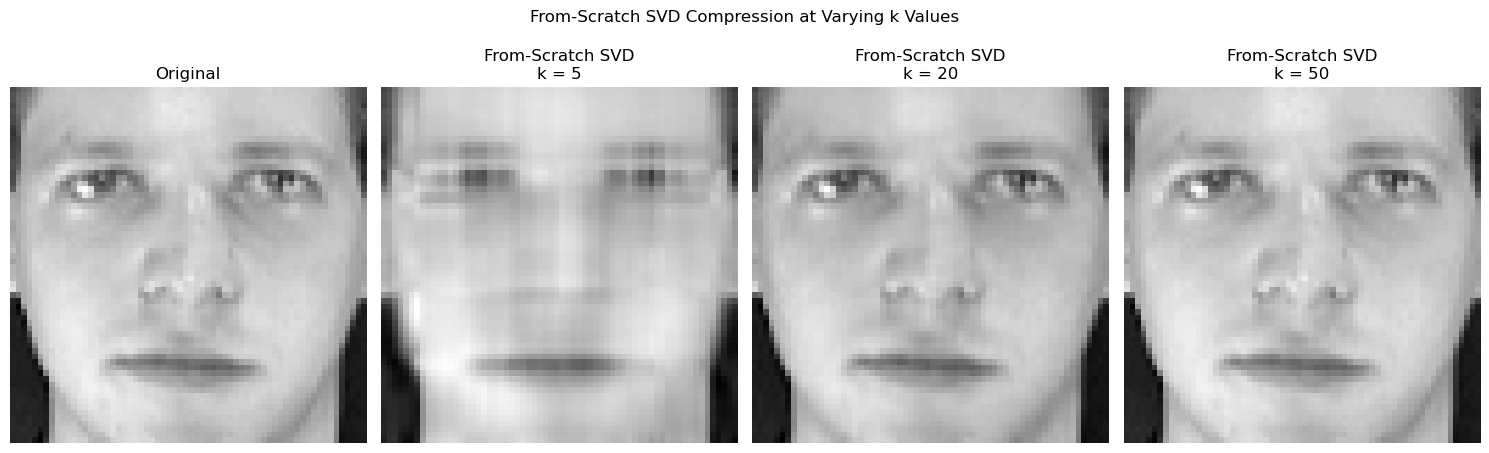

In [8]:

# Compress image using from-scratch SVD
k = 20
U, S, VT = power_iteration_svd(image, k)
compressed_image = U @ np.diag(S) @ VT

# Apply from-scratch SVD for multiple k values
ks = [5, 20, 50]
reconstructed_images = []

for k in ks:
    U_k, S_k, VT_k = power_iteration_svd(image, k)
    compressed_k = U_k @ np.diag(S_k) @ VT_k
    reconstructed_images.append((k, compressed_k))

# Plot original and reconstructed images side by side
fig, axes = plt.subplots(1, len(ks) + 1, figsize=(15, 5))

# Original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

# Compressed images
for i, (k, img_k) in enumerate(reconstructed_images):
    axes[i + 1].imshow(img_k, cmap='gray')
    axes[i + 1].set_title(f"From-Scratch SVD\nk = {k}")
    axes[i + 1].axis('off')

plt.suptitle("From-Scratch SVD Compression at Varying k Values")
plt.tight_layout()
plt.show()

- **k = 5**: Similar to NumPy’s result — blocky and blurry but recognizable structure.
- **k = 20**: Clearly defined facial features appear; the result is nearly equivalent to NumPy’s SVD at the same level.
- **k = 50**: Almost indistinguishable from the original. Fine details and shading are well preserved.

Achieves nearly identical results compared to the built-in method — validating its correctness and confirming that **power iteration SVD can be both educational and functional** for low-rank matrix approximation.


## Conclusion 

###  Summary
Applied **Singular Value Decomposition (SVD)** to compress grayscale facial images using two methods:
1. NumPy’s built-in `np.linalg.svd()`
2. A from-scratch SVD using **power iteration and deflation**

Both methods successfully reconstructed compressed versions of the original image at various values of $ k $, showing that SVD:
- Can reduce storage significantly while retaining core visual content.
- Makes it easy to control the trade-off between compression level and image quality.


### Comparison 

Both methods give visually comparable results. While the from-scratch version is slower and less numerically stable at high `k`, it **accurately approximates key structure** — validating your implementation.
**Differences** are minor in output quality, but large in implementation complexity and performance as the from scratch version is a lot slower and iterative but can build more intuition in educational context.


### Takeaways

- SVD is highly effective for **dimensionality reduction**, particularly in image and signal processing tasks.
- Keeping just a fraction of components (e.g., 20/64) can reconstruct recognizable faces — great for lossy compression.
